In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mathphys.functions import save, load
import pymodels
import pyaccel
from idanalysis.analysis import StorageRingAnalysis
from idanalysis.idsdata import IVU18Data, DELTA52Data, APU22Data
from idanalysis.analysis import KickmapAnalysis
from idanalysis import IDKickMap
from fieldmaptrack import Beam
from apsuite.optics_analysis.tune_correction import TuneCorr
from apsuite.orbcorr import OrbRespmat
import time

In [2]:
def get_idcs(fam_name, mod, idc_id):
    idc = np.array(pyaccel.lattice.find_indices(mod, 'fam_name', fam_name))
    idx = np.argsort(np.abs(idc_id-idc))[:2]
    return idc[idx]

In [3]:
# BEAMLINE
beamline = 'EMA'

# Here we need to use a LOCO fitted model
model = pymodels.si.create_accelerator()
tunecorr = TuneCorr(model=model, acc='SI')
tunecorr.correct_parameters((49.16, 14.22))

model_ivu = pymodels.si.create_accelerator()
tunecorr = TuneCorr(model=model_ivu, acc='SI')
tunecorr.correct_parameters((49.16, 14.22))

1

# Test kickmap insertion

In [4]:
beam = Beam(3)
ivu_data = IVU18Data()
kmap_fname = ivu_data.get_kickmap_filename(gap=4.3)
kick_anl = KickmapAnalysis(kmap_fname)

_, ry0, _, pyf, rxf, ryf = kick_anl.get_kicks_at_plane('y', 0)
rx0, _, pxf, _, rxf, ryf = kick_anl.get_kicks_at_plane('x', 0)
pyf *=108/5
pxf *=108/5
kld = (np.diff(pyf)/np.diff(ry0)*beam.brho)[int(len(np.diff(pyf))/2)]
klf = (np.diff(pxf)/np.diff(rx0)*beam.brho)[int(len(np.diff(pxf))/2)]
print(klf)
print(kld)

idkickmap = IDKickMap()
posx = rx0
posy = ry0
cxx = 0*klf/beam.brho*5/108
cyy = 0*kld/beam.brho*5/108
idkickmap.generate_linear_kickmap(beam.brho, posx=posx, posy=posy, cxx=cxx, cyy=cyy, verbose=False)
idkickmap.kmap_idlen = 2
idkickmap.save_kickmap_file('jacobian_0.txt')

0.0018889105218772458
-0.24985821313750645


In [5]:
opt_resp = []
dkl = 0.001
dkls = [[dkl, 0], [0, dkl]]
components = ['x', 'y']
for i, dk in enumerate(zip(dkls)):
    dklx = dk[0][0]
    dkly = dk[0][1]

    cxx = dklx/beam.brho
    cyy = dkly/beam.brho
    idkickmap.generate_linear_kickmap(beam.brho, posx=posx, posy=posy, cxx=cxx, cyy=cyy, verbose=False)
    idkickmap.kmap_idlen = 2
    idkickmap.save_kickmap_file('jacobian_' + components[i] + '.txt')

In [6]:
kmap_fname = 'jacobian_y.txt'
kick_anl = KickmapAnalysis(kmap_fname)

_, ry0, _, pyf, rxf, ryf = kick_anl.get_kicks_at_plane('y', 0)
rx0, _, pxf, _, rxf, ryf = kick_anl.get_kicks_at_plane('x', 0)
pyf *=1
pxf *=1
kld = (np.diff(pyf)/np.diff(ry0)*beam.brho)[int(len(np.diff(pyf))/2)]
klf = (np.diff(pxf)/np.diff(rx0)*beam.brho)[int(len(np.diff(pxf))/2)]
print(klf)
print(kld)

0.0
0.0009999744133018472


# Make response matrix

In [7]:
ivu_idcs = pyaccel.lattice.find_indices(model, "fam_name", "IVU18")
if beamline == 'EMA':
    ivu_idcs = ivu_idcs[:2]
    idx_subsec = 0
elif beamline == 'PAINEIRA':
    ivu_idcs = ivu_idcs[2:]
    idx_subsec = 1

# Calculate nominal jacobian
respm = OrbRespmat(model, 'SI', dim='6d', corr_system='SOFB')
mat0 = respm.get_respm()

In [8]:
import pyaccel.optics


ivu_data = IVU18Data()
kmap_fname = ivu_data.get_kickmap_filename(gap=4.3)
kick_anl = KickmapAnalysis(kmap_fname)

# Insert kickmap with zero kicks
ring_anl = StorageRingAnalysis()
ring_anl.add_id_to_model(subsec=ivu_data.subsecs[idx_subsec], kmap_fname='jacobian_0.txt', fam_name=ivu_data.id_famname, rescale_kicks=108/5)
model_ivu = ring_anl.set_model_ids(model)

Model without ID:
length : 518.3899 m
tunex  : 49.160000
tuney  : 14.220000

Model with ID:
length : 518.3899 m
tunex  : 49.160000
tuney  : 14.220000



In [9]:
opt_resp = []
dkl = 0.001
dkls = [[dkl, 0], [0, dkl]]
knames = ['jacobian_x.txt', 'jacobian_y.txt']
for i, dk in enumerate(zip(dkls)):
    kname = knames[i]
    ring_anl = StorageRingAnalysis()
    ring_anl.nom_model = model
    ring_anl.add_id_to_model(subsec=ivu_data.subsecs[idx_subsec], kmap_fname=kname, fam_name=ivu_data.id_famname, rescale_kicks=1)
    model_ivu = ring_anl.set_model_ids(model_ivu)

    dmat = respm.get_respm() - mat0
    dmat[:, -1] *= 1e6  # convert from m/hz to um/Hz
    dmat /= dkl
    opt_resp.append(dmat.ravel())

opt_resp = np.array(opt_resp)

Model without ID:
length : 518.3899 m
tunex  : 49.160000
tuney  : 14.220000

Model with ID:
length : 518.3899 m
tunex  : 49.159986
tuney  : 14.220000

Model without ID:
length : 518.3899 m
tunex  : 49.159986
tuney  : 14.220000

Model with ID:
length : 518.3899 m
tunex  : 49.160000
tuney  : 14.219987



0.0018889105218772458
-0.24985821313750645


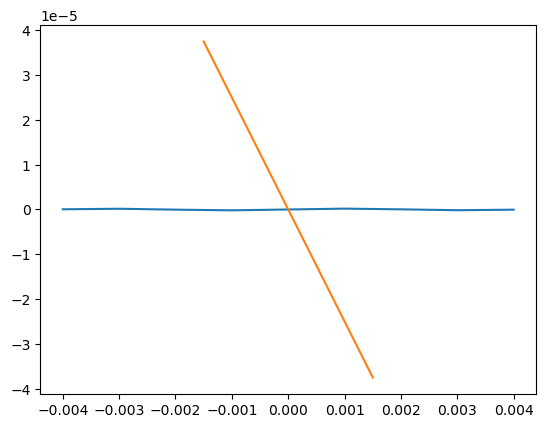

In [10]:
beam = Beam(3)
ivu_data = IVU18Data()
kmap_fname = ivu_data.get_kickmap_filename(gap=4.3)
kick_anl = KickmapAnalysis(kmap_fname)

_, ry0, _, pyf, rxf, ryf = kick_anl.get_kicks_at_plane('y', 0)
rx0, _, pxf, _, rxf, ryf = kick_anl.get_kicks_at_plane('x', 0)
pyf *=108/5
pxf *=108/5
kld = (np.diff(pyf)/np.diff(ry0)*beam.brho)[int(len(np.diff(pyf))/2)]
klf = (np.diff(pxf)/np.diff(rx0)*beam.brho)[int(len(np.diff(pxf))/2)]
print(klf)
print(kld)

plt.plot(rx0, pxf)
plt.plot(ry0, pyf)

In [11]:
ring_anl = StorageRingAnalysis()
ring_anl.nom_model = model
ring_anl.add_id_to_model(subsec=ivu_data.subsecs[0], kmap_fname=kmap_fname, fam_name=ivu_data.id_famname, rescale_kicks=108/5)
model_ivu = ring_anl.set_model_ids(model_ivu)
# for i, ivu_idx in enumerate(ivu_idcs):
#     ivu_length = model[ivu_idx].length
#     quad = pyaccel.elements.quadrupole('IVU18', length=ivu_length, K=0.0004)
#     model_ivu[ivu_idx] = quad

respm_ivu = OrbRespmat(model_ivu, 'SI', dim='6d', corr_system='SOFB')
mat_ivu = respm_ivu.get_respm()
orm = mat_ivu - mat0
kl_ivu, *_ = np.linalg.lstsq(opt_resp.T, orm.ravel(), rcond=None)

Model without ID:
length : 518.3899 m
tunex  : 49.160000
tuney  : 14.219987

Model with ID:
length : 518.3899 m
tunex  : 49.159974
tuney  : 14.223229



In [12]:
kl_ivu

array([ 0.00188593, -0.24290255])

In [13]:
cxx = kl_ivu[0]/beam.brho
cyy = kl_ivu[1]/beam.brho
idkickmap.generate_linear_kickmap(beam.brho, posx=posx, posy=posy, cxx=cxx, cyy=cyy, verbose=False)
idkickmap.kmap_idlen = 2
idkickmap.save_kickmap_file('linear_kickmap.txt')

0.0018858944498167014
-0.24290517710458795


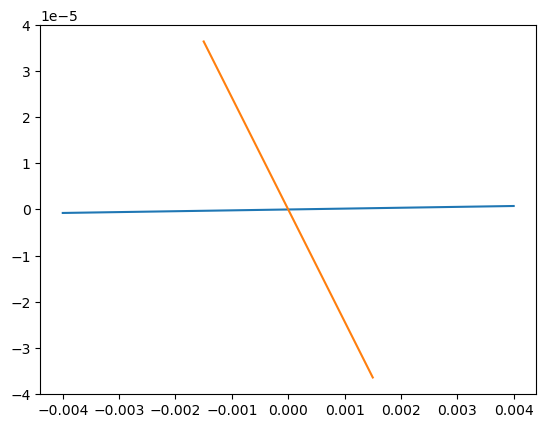

In [14]:
beam = Beam(3)
ivu_data = IVU18Data()
kmap_fname = 'linear_kickmap.txt'
kick_anl = KickmapAnalysis(kmap_fname)

_, ry0, _, pyf, rxf, ryf = kick_anl.get_kicks_at_plane('y', 0)
rx0, _, pxf, _, rxf, ryf = kick_anl.get_kicks_at_plane('x', 0)
kld = (np.diff(pyf)/np.diff(ry0)*beam.brho)[int(len(np.diff(pyf))/2)]
klf = (np.diff(pxf)/np.diff(rx0)*beam.brho)[int(len(np.diff(pxf))/2)]
print(klf)
print(kld)

plt.plot(rx0, pxf)
plt.plot(ry0, pyf)

In [15]:
model = pymodels.si.create_accelerator()

ivu_idcs = pyaccel.lattice.find_indices(model, 'fam_name', 'IVU18')
if beamline == 'EMA':
    idc_id = ivu_idcs[0]
elif beamline == 'PAINEIRA':
    idc_id = ivu_idcs[2]

idc_qn = []
idc_qn.extend(get_idcs('QFB', model, idc_id))
idc_qn.extend(get_idcs('QDB1', model, idc_id))
idc_qn.extend(get_idcs('QDB2', model, idc_id))

kls0 = np.zeros(len(idc_qn))
for i, idx in enumerate(idc_qn):
    kls0[i] = model[idx].KL

tunecorr = TuneCorr(model=model, acc='SI', idcs_out=idc_qn)
tunecorr.correct_parameters((49.16, 14.22))

kls = np.zeros(len(idc_qn))
for i, idx in enumerate(idc_qn):
    kls[i] = model[idx].KL

dkl = kls - kls0

In [16]:
dkl

array([0., 0., 0., 0., 0., 0.])

In [17]:
dkl

array([0., 0., 0., 0., 0., 0.])

Model without ID:
length : 518.3899 m
tunex  : 49.160000
tuney  : 14.220000

Model with ID:
length : 518.3899 m
tunex  : 49.159974
tuney  : 14.223139

element indices for straight section begin and end:
ID08SB [2260, 2307]
local quadrupole fams: 
ID08SB {'QFB_ID': [2266, 2300], 'QDB1_ID': [2260, 2306], 'QDB2_ID': [2272, 2294]}
symmetrizing ID IVU18 in subsec ID08SB
iteration #1, ΔK: [ 0.00761727  0.0031468  -0.04125576]
iteration #2, ΔK: [-2.39263992e-04  7.98271080e-05  9.64431996e-04]
iteration #3, ΔK: [-9.65311788e-07 -6.45169819e-07  4.85107751e-06]
iteration #4, ΔK: [ 9.32458783e-09  1.16017587e-08 -5.34466006e-08]
iteration #5, ΔK: [-7.44066145e-09 -9.11088266e-09  4.22045131e-08]
iteration #6, ΔK: [ 2.10939735e-08  2.58447219e-08 -1.19694574e-07]
iteration #7, ΔK: [-7.21917764e-08 -8.84645130e-08  4.09682835e-07]
QFB_ID    ΔK:    +0.179 % 
QDB1_ID   ΔK:    -0.160 % 
QDB2_ID   ΔK:    +1.173 % 


init    tunes: 49.158636048 14.227002524
iter #1 tunes: 49.159999947 14.220000170
ite

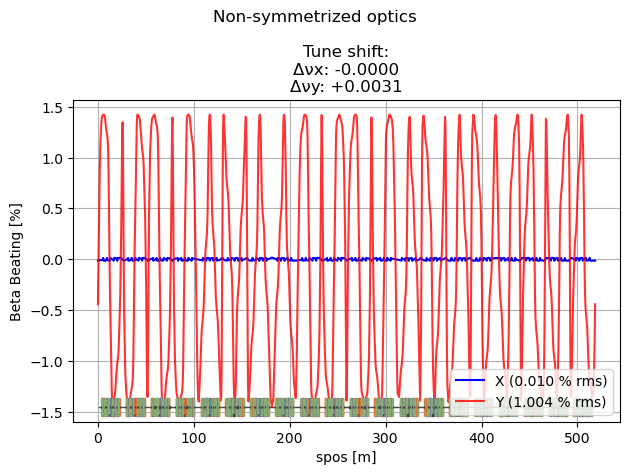

symmetrized optics but uncorrect tunes:
dtunex: -1e-03
dtuney: +7e-03
bbetax: 0.168 % rms, 0.860 % absmax
bbetay: 0.089 % rms, 3.341 % absmax



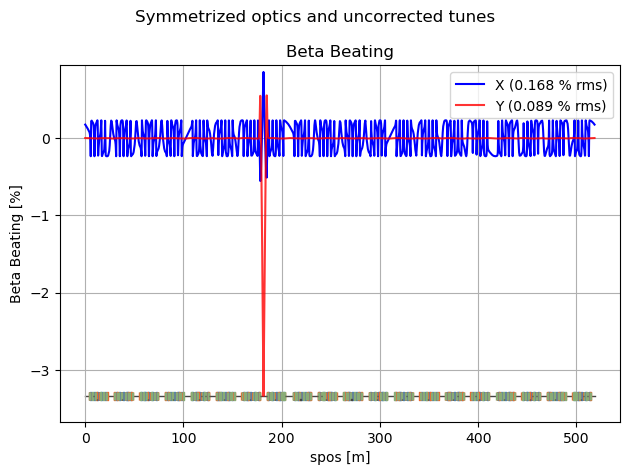

symmetrized optics and corrected tunes:
dtunex: -4e-08
dtuney: +8e-08
bbetax: 0.212 % rms, 0.799 % absmax
bbetay: 0.218 % rms, 3.166 % absmax


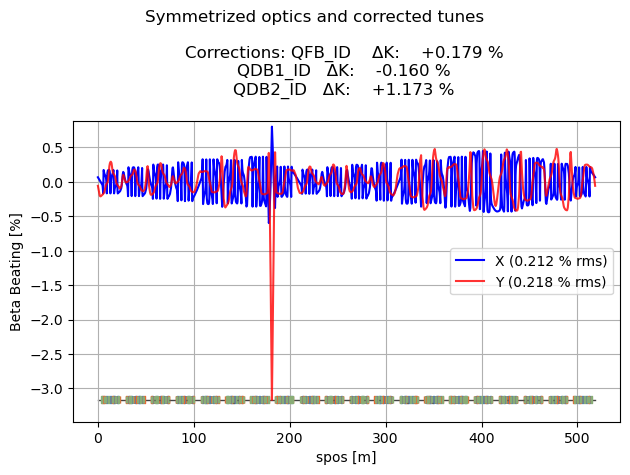

True

In [24]:
model = pymodels.si.create_accelerator()
tunecorr = TuneCorr(model=model, acc='SI')
tunecorr.correct_parameters((49.16, 14.22))

model_id = pymodels.si.create_accelerator()
tunecorr_id = TuneCorr(model=model_id, acc='SI')
tunecorr_id.correct_parameters((49.16, 14.22))

twiss_nom, *_ = pyaccel.optics.calc_twiss(model, indices='closed')

ring_anl = StorageRingAnalysis()
ring_anl.nom_model = model

ivu_data = IVU18Data()
kmap_fname = ivu_data.get_kickmap_filename(gap=4.3)
kmap_fname = 'linear_kickmap.txt'

ring_anl.add_id_to_model(subsec=ivu_data.subsecs[idx_subsec], kmap_fname=kmap_fname, fam_name=ivu_data.id_famname, rescale_kicks=1)
model_ivu = ring_anl.set_model_ids(model_id)

twiss_no_corr, twiss_beta_corr, twiss_tune_corr, stg = ring_anl.do_optics_corrections(exclude_loc_qn=False)
ring_anl.plot_optics_corr_results(twiss_nom, twiss_no_corr, twiss_beta_corr, twiss_tune_corr, stg)

In [25]:
print(twiss_tune_corr.mux[-1]/2/np.pi)
print(twiss_tune_corr.muy[-1]/2/np.pi)

49.159999946781504
14.220000169975902


In [26]:
# model = pymodels.si.create_accelerator()

ivu_idcs = pyaccel.lattice.find_indices(model, 'fam_name', 'IVU18')
if beamline == 'EMA':
    idc_id = ivu_idcs[0]
elif beamline == 'PAINEIRA':
    idc_id = ivu_idcs[2]

idc_qn = []
idc_qn.extend(get_idcs('QFB', model, idc_id))
idc_qn.extend(get_idcs('QDB1', model, idc_id))
idc_qn.extend(get_idcs('QDB2', model, idc_id))

kls0 = np.zeros(len(idc_qn))
for i, idx in enumerate(idc_qn):
    kls0[i] = model[idx].KL

kls = np.zeros(len(idc_qn))
for i, idx in enumerate(idc_qn):
    kls[i] = model_id[idx].KL

dkl = kls - kls0

In [27]:
dkl

array([ 0.0022131 ,  0.0022131 ,  0.00045163,  0.00045163, -0.00564007,
       -0.00564007])

Model without ID:
length : 518.3899 m
tunex  : 49.160000
tuney  : 14.220000

Model with ID:
length : 518.3899 m
tunex  : 49.159974
tuney  : 14.223139

element indices for straight section begin and end:
ID08SB [2260, 2307]
local quadrupole fams: 
ID08SB {'QFB_ID': [2266, 2300], 'QDB1_ID': [2260, 2306], 'QDB2_ID': [2272, 2294]}
symmetrizing ID IVU18 in subsec ID08SB
iteration #1, ΔK: [ 0.00761727  0.0031468  -0.04125576]
iteration #2, ΔK: [-2.39263992e-04  7.98271080e-05  9.64431996e-04]
iteration #3, ΔK: [-9.65311788e-07 -6.45169819e-07  4.85107751e-06]
iteration #4, ΔK: [ 9.32458783e-09  1.16017587e-08 -5.34466006e-08]
iteration #5, ΔK: [-7.44066145e-09 -9.11088266e-09  4.22045131e-08]
iteration #6, ΔK: [ 2.10939735e-08  2.58447219e-08 -1.19694574e-07]
iteration #7, ΔK: [-7.21917764e-08 -8.84645130e-08  4.09682835e-07]
QFB_ID    ΔK:    +0.179 % 
QDB1_ID   ΔK:    -0.160 % 
QDB2_ID   ΔK:    +1.173 % 


init    tunes: 49.158636048 14.227002524
iter #1 tunes: 49.159999982 14.220000097
ite

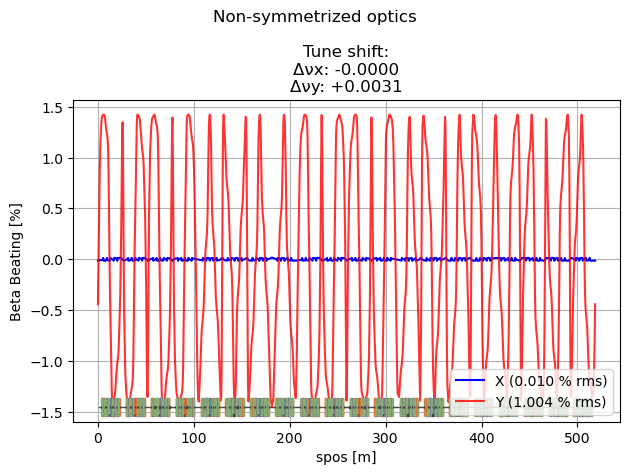

symmetrized optics but uncorrect tunes:
dtunex: -1e-03
dtuney: +7e-03
bbetax: 0.168 % rms, 0.860 % absmax
bbetay: 0.089 % rms, 3.341 % absmax



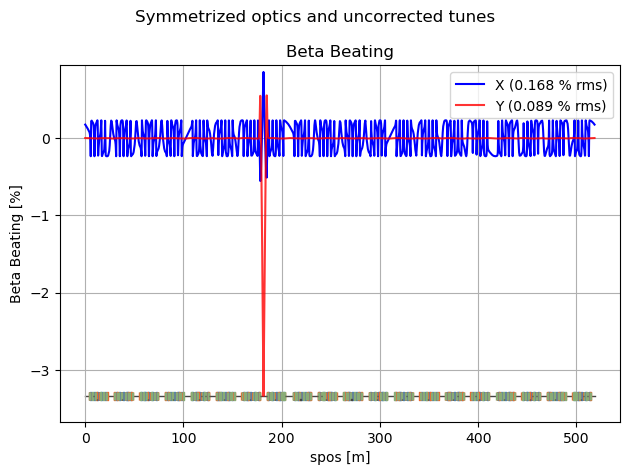

symmetrized optics and corrected tunes:
dtunex: -2e-10
dtuney: +6e-09
bbetax: 0.177 % rms, 0.780 % absmax
bbetay: 0.171 % rms, 3.080 % absmax


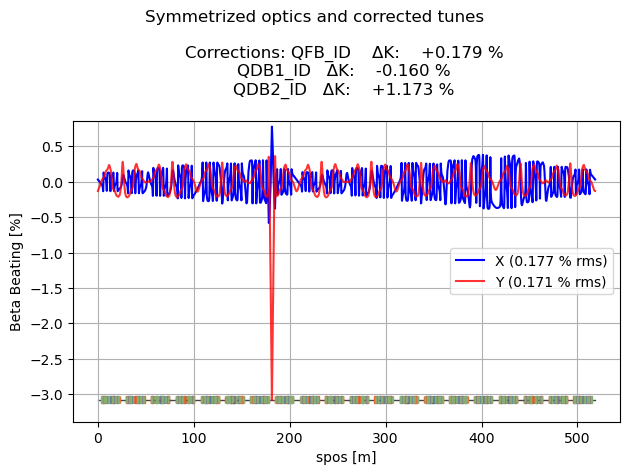

True

In [28]:
model = pymodels.si.create_accelerator()
tunecorr = TuneCorr(model=model, acc='SI')
# tunecorr.correct_parameters((49.16, 14.22))

model_id = pymodels.si.create_accelerator()
tunecorr_id = TuneCorr(model=model_id, acc='SI')
# tunecorr_id.correct_parameters((49.16, 14.22))

twiss_nom, *_ = pyaccel.optics.calc_twiss(model, indices='closed')

ring_anl = StorageRingAnalysis()
ring_anl.nom_model = model

ivu_data = IVU18Data()
kmap_fname = ivu_data.get_kickmap_filename(gap=4.3)
kmap_fname = 'linear_kickmap.txt'

ring_anl.add_id_to_model(subsec=ivu_data.subsecs[idx_subsec], kmap_fname=kmap_fname, fam_name=ivu_data.id_famname, rescale_kicks=1)
model_ivu = ring_anl.set_model_ids(model_id)

twiss_no_corr, twiss_beta_corr, twiss_tune_corr, stg = ring_anl.do_optics_corrections(exclude_loc_qn=True)
ring_anl.plot_optics_corr_results(twiss_nom, twiss_no_corr, twiss_beta_corr, twiss_tune_corr, stg)

In [29]:
ivu_idcs = pyaccel.lattice.find_indices(model, 'fam_name', 'IVU18')
if beamline == 'EMA':
    idc_id = ivu_idcs[0]
elif beamline == 'PAINEIRA':
    idc_id = ivu_idcs[2]

idc_qn = []
idc_qn.extend(get_idcs('QFB', model, idc_id))
idc_qn.extend(get_idcs('QDB1', model, idc_id))
idc_qn.extend(get_idcs('QDB2', model, idc_id))

kls0 = np.zeros(len(idc_qn))
for i, idx in enumerate(idc_qn):
    kls0[i] = model[idx].KL

kls = np.zeros(len(idc_qn))
for i, idx in enumerate(idc_qn):
    kls[i] = model_id[idx].KL

dkl = kls - kls0
dkl

array([ 0.00215783,  0.00215783,  0.00053279,  0.00053279, -0.00549988,
       -0.00549988])

In [15]:
repos = '/opt/mamba_files/mamba/envs/sirius/repos/idanalysis/idanalysis'
repos = repos[:-10]
repos

'/opt/mamba_files/mamba/envs/sirius/repos/idanalysis/'